In [1]:
import os
from os.path import join
import numpy as np
import sklearn.neighbors as skn
import tqdm

import torch
import torch_geometric as pyg
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('style.mcstyle')


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [30]:
dname = 'AMICOdC100' # 'Lorenzo' # 

datapath = join('data/processed', dname)
print('Loading from:', datapath)
x_train = np.load(join(datapath, 'x_batch_train.npy'), allow_pickle=True)
theta_train = np.load(join(datapath, 'theta_batch_train.npy'), allow_pickle=True)
x_test = np.load(join(datapath, 'x_batch_test.npy'), allow_pickle=True)
theta_test = np.load(join(datapath, 'theta_batch_test.npy'), allow_pickle=True)

x = np.concatenate(x_train, axis=0)
theta = np.concatenate(theta_train, axis=0)

Loading from: data/processed/AMICOdC100


[13.42134064]


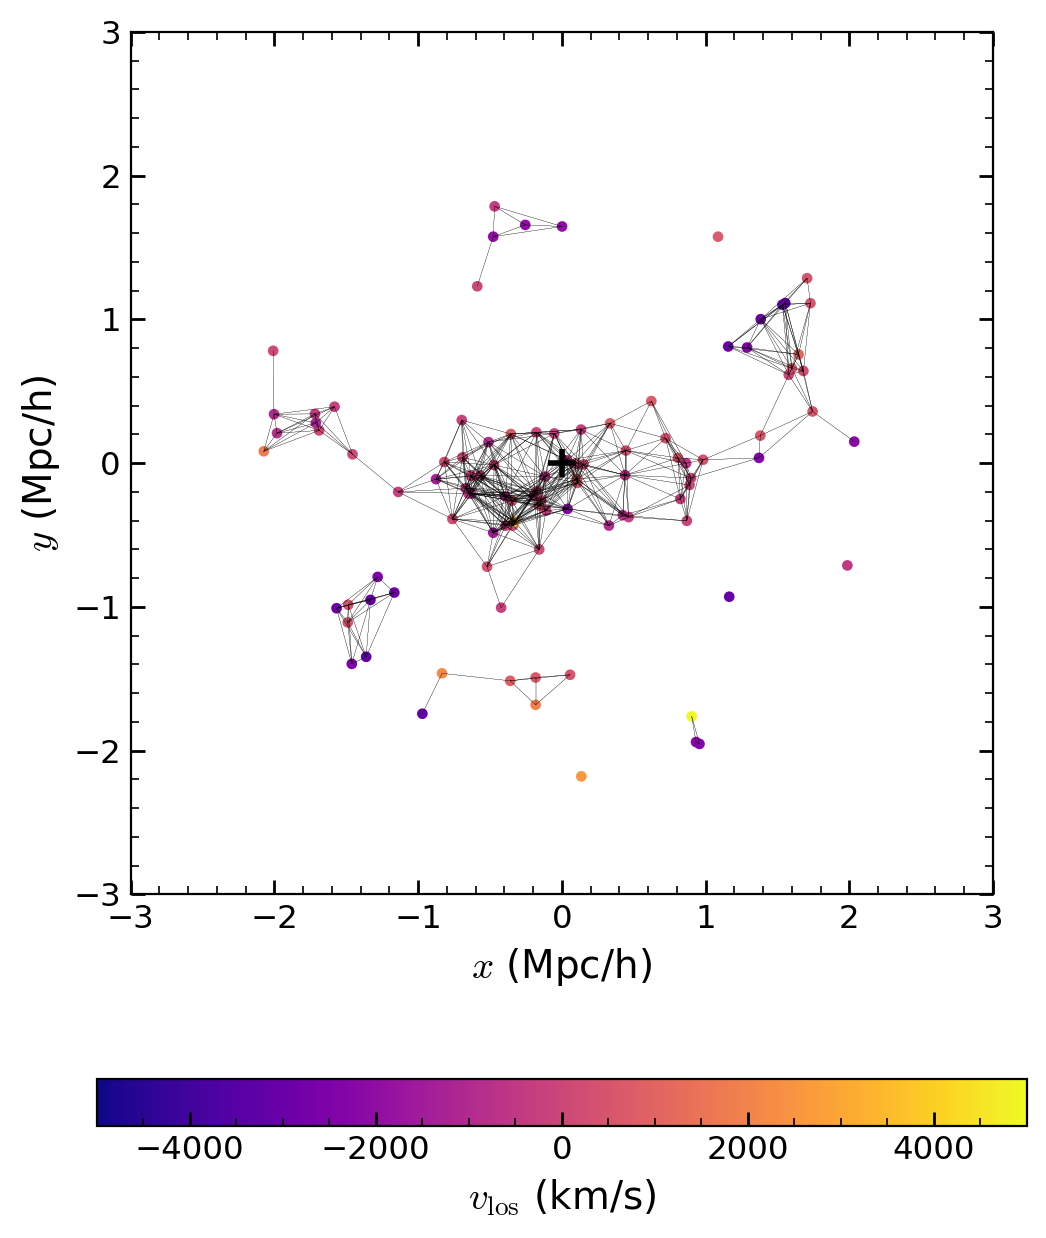

In [74]:
rmax = 0.5

i = np.random.choice(np.argwhere(theta_train[:,0]<13.5).flatten())
x0 = x_train[i]
theta0 = theta_train[i]
R0 = np.sqrt(x0[:,0]**2 + x0[:,1]**2)
print(theta0)
graph = skn.radius_neighbors_graph(x0[:,:2], rmax, mode='distance', include_self=False).toarray()
# graph = skn.kneighbors_graph(x0[:,:2], 5, mode='distance', include_self=False).toarray()


def plot_graph(x, y, graph, ax, c='k'):
    for i in range(x.shape[0]):
        for j in range(x.shape[0]):
            if graph[i,j] > 0:
                ax.plot([x[i], x[j]], [y[i], y[j]], c='k', lw=0.075)
    return ax.scatter(x, y, c=c, marker='o', s=8, 
                      cmap='plasma', norm='linear', vmin=-5e3, vmax=5e3)


f, axs = plt.subplots(1, 1, figsize=(6,8), gridspec_kw={'wspace': 0.3})
axs = [axs]

im = plot_graph(x0[:,0], x0[:,1], graph, axs[0], c=x0[:,2])
axs[0].plot(0,0,'k+', ms=10, mew=2)
plt.colorbar(im, label='$v_\mathrm{los}$ (km/s)', orientation="horizontal")

axs[0].set_xlabel('$x$ (Mpc/h)')
axs[0].set_ylabel('$y$ (Mpc/h)')
axs[0].set_xlim(-3,3)
axs[0].set_ylim(-3,3)
axs[0].set_aspect('equal')
axs[0].grid(False)

# axs[1].axhline(0, c='k', ls='--')
# plot_graph(R0, x0[:,2], graph, axs[1])

# axs[1].set_xlabel('$R$ (Mpc/h)')
# axs[1].set_ylabel('$v_\mathrm{los}$ (km/s)')
# axs[1].set_xlim(0,3)
# axs[1].set_ylim(-5000,5000)

# f.savefig('images/graph_ex.png', dpi=300, bbox_inches='tight')

In [35]:
def get_adjacency(x, rmax=1.2):
    graph = skn.radius_neighbors_graph(x[:,:2], rmax, mode='distance', include_self=True).toarray()
    adj = np.nonzero(graph)
    return tuple(adj)

rmax=1.5
adj_train = [get_adjacency(x_, rmax=rmax) for x_ in x_train]
adj_test = [get_adjacency(x_, rmax=rmax) for x_ in x_test]

In [8]:
# normalize
x_mu, x_std = x.mean(axis=0), x.std(axis=0)
t_mu, t_std = theta.mean(axis=0), theta.std(axis=0)

x_train = [(x_ - x_mu)/x_std for x_ in x_train]
theta_train = [(t_ - t_mu)/t_std for t_ in theta_train]
x_test = [(x_ - x_mu)/x_std for x_ in x_test]
theta_test = [(t_ - t_mu)/t_std for t_ in theta_test]

x_train = np.array(x_train, dtype=object)
theta_train = np.array(theta_train)
adj_train = np.array(adj_train, dtype=object)
x_test = np.array(x_test, dtype=object)
theta_test = np.array(theta_test)
adj_test = np.array(adj_test, dtype=object)

In [9]:
class GraphData(Dataset):
    def __init__(self, x_batch, theta_batch, adj_batch):
        self.x_batch = x_batch
        self.theta_batch = theta_batch
        self.adj_batch = adj_batch

    def __len__(self):
        return len(self.x_batch)

    def __getitem__(self, idx):
        x = torch.tensor(self.x_batch[idx], dtype=torch.float)
        theta = torch.tensor(self.theta_batch[idx], dtype=torch.float)
        edge_index = torch.tensor(np.stack(self.adj_batch[idx])) # .clone().detach()

        theta = theta[0:1]  # only mass
        return x, edge_index, theta

# define train and test dataloaders
ind = 1
skip = 0
train_dataset = GraphData(
    x_train,
    theta_train,
    adj_train
)

test_dataset = GraphData(
    x_test,
    theta_test,
    adj_test
)


train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [10]:
from torch_geometric import nn as gnn
from torch_geometric.nn import aggr
import torch.nn.functional as F

class DenseNetwork(torch.nn.Module):
    def __init__(self, in_channels, dense_channels, out_channels, drop_p=0.1):
        super().__init__()
        self.in_channels = in_channels
        self.dense_channels = dense_channels
        self.out_channels = out_channels
        self.drop_p = drop_p

        self.global_aggr = aggr.MultiAggregation(
            aggrs=['sum', 'mean', 'median', 'std', 'min', 'max'],
            mode='cat'
        )
        self._build_dnn(in_channels*len(self.global_aggr.aggrs))
        self.dropout =  torch.nn.Dropout(drop_p)

    def _build_dnn(self, in_channels):
        self.fc1 = torch.nn.Linear(in_channels, self.dense_channels[0])
        self.fcs = torch.nn.ModuleList(
            [torch.nn.Linear(self.dense_channels[i], self.dense_channels[i+1])
             for i in range(0, len(self.dense_channels)-1)])
        self.fc2 = torch.nn.Linear(self.dense_channels[-1], self.out_channels)
    
    def dnn(self, x):
        x = F.relu(self.fc1(x))
        for fc in self.fcs:
            x = self.dropout(x)
            x = F.relu(fc(x))
        x = self.fc2(x)
        return x
    
    def global_features(self, x):
        x = self.global_aggr(x)[0]
        x = torch.nan_to_num(x, nan=1., posinf=1., neginf=1.)
        return x
    
    def forward(self, x, edge_index):
        x = self.global_features(x)
        x = self.dnn(x)
        return x


class GATNetwork(DenseNetwork):
    def __init__(
        self, in_channels, gcn_channels, gcn_heads,
        dense_channels, out_channels, drop_p=0.1
    ):
        super().__init__(in_channels, dense_channels, out_channels, drop_p)
        self.gcn_channels = gcn_channels
        self.gcn_heads = gcn_heads

        self.graph_aggr = aggr.MultiAggregation(
            aggrs=['sum', 'mean', 'median', 'std', 'min', 'max', aggr.SoftmaxAggregation(learn=True)],
            mode='cat'
        )
        
        self._build_gnn()
        self._build_dnn(gcn_channels[-1]*len(self.graph_aggr.aggrs) + 
                        in_channels*len(self.global_aggr.aggrs))
    
    def _build_gnn(self):
        self.conv1 = gnn.GATv2Conv(self.in_channels, self.gcn_channels[0], heads=self.gcn_heads[0])
        self.convs = torch.nn.ModuleList(
            [gnn.GATv2Conv(self.gcn_channels[i]*self.gcn_heads[i],
                           self.gcn_channels[i+1], heads=self.gcn_heads[i+1])
             for i in range(len(self.gcn_channels)-2)]
        )
        self.conv2 = gnn.GATv2Conv(
            self.gcn_channels[-2]*self.gcn_heads[-2],
            self.gcn_channels[-1], heads=self.gcn_heads[-1], concat=False)

    def gnn(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        for conv in self.convs:
            x = F.relu(conv(x, edge_index))
            x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

    def forward(self, x, edge_index):
        globfeat = self.global_features(x)

        x = self.gnn(x, edge_index)
        x = self.graph_aggr(x)[0]
        x = torch.cat([x, globfeat], dim=-1)
        x = self.dnn(x)
        return x

class SAGENetwork(DenseNetwork):
    def __init__(
        self, in_channels, gcn_channels,
        dense_channels, out_channels, drop_p=0.1
    ):
        super().__init__(in_channels, dense_channels, out_channels, drop_p)
        self.gcn_channels = gcn_channels

        self.graph_aggr = aggr.MultiAggregation(
            aggrs=['sum', 'mean', 'median', 'std', 'min', 'max', aggr.SoftmaxAggregation(learn=True)],
            mode='cat'
        )
        
        self._build_gnn()
        self._build_dnn(gcn_channels[-1]*len(self.graph_aggr.aggrs) + 
                        in_channels*len(self.global_aggr.aggrs))
    
    def _build_gnn(self):
        self.conv1 = gnn.SAGEConv(self.in_channels, self.gcn_channels[0])
        self.convs = torch.nn.ModuleList(
            [gnn.SAGEConv(self.gcn_channels[i], self.gcn_channels[i+1])
             for i in range(len(self.gcn_channels)-1)]
        )

    def gnn(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        for conv in self.convs:
            x = F.relu(conv(x, edge_index))
            x = self.dropout(x)
        return x

    def forward(self, x, edge_index):
        globfeat = self.global_features(x)

        x = self.gnn(x, edge_index)
        x = self.graph_aggr(x)[0]
        x = torch.cat([x, globfeat], dim=-1)
        x = self.dnn(x)
        return x

In [18]:
# define the model
model = GATNetwork(
    in_channels=3, gcn_channels=[8, 16, 16, 16, 32], gcn_heads=[4,4,4,4,1],
    dense_channels=[32, 32, 16], out_channels=2,
)
# model = DenseNetwork(
#     in_channels=3,
#     dense_channels=[32, 32, 16], out_channels=1,
# )
# model = SAGENetwork(
#     in_channels=3, gcn_channels=[8, 16, 16, 16, 32],
#     dense_channels=[32, 32, 16], out_channels=1,
# )
model.to(device)


# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=3e-5, weight_decay=1e-1)

# print summary
summary(model)

Layer (type:depth-idx)                   Param #
GATNetwork                               --
├─MultiAggregation: 1-1                  --
│    └─ModuleList: 2-1                   --
│    │    └─SumAggregation: 3-1          --
│    │    └─MeanAggregation: 3-2         --
│    │    └─MedianAggregation: 3-3       --
│    │    └─StdAggregation: 3-4          --
│    │    └─MinAggregation: 3-5          --
│    │    └─MaxAggregation: 3-6          --
│    └─FusedAggregation: 2-2             --
├─Linear: 1-2                            7,776
├─ModuleList: 1-3                        --
│    └─Linear: 2-3                       1,056
│    └─Linear: 2-4                       528
├─Linear: 1-4                            34
├─Dropout: 1-5                           --
├─MultiAggregation: 1-6                  --
│    └─ModuleList: 2-5                   --
│    │    └─SumAggregation: 3-7          --
│    │    └─MeanAggregation: 3-8         --
│    │    └─MedianAggregation: 3-9       --
│    │    └─StdAggre

In [35]:
def criterion(pred, true, reduction='mean'):
    pred, true = torch.atleast_2d(pred), torch.atleast_2d(true)
    # return F.mse_loss(pred, true, reduction=reduction)
    return F.mse_loss(pred[:,1], (true[:,0]-pred[:,0])**2, reduction=reduction)


def train(model, optimizer, loader, device, bs=32, verbose=False):
    model.train()

    loss_all = 0
    train_iter = iter(loader)
    for i in tqdm.tqdm(range(len(loader)//bs+1), disable=not verbose):
        if i*bs >= len(loader):
            break
        optimizer.zero_grad()
        loss = torch.tensor(0, dtype=torch.float, device=device)
        for j in range(bs):
            try:
                xi, edgei, thetai = next(train_iter)
            except StopIteration:
                break
            xi, edgei, thetai = xi[0], edgei[0], thetai[0]
            out = model(xi, edgei)
            loss += criterion(out, thetai, reduction='sum')
        loss.backward()
        loss_all += loss.item()
        optimizer.step()
    return loss_all / len(loader.dataset)

def test(model, loader):
    model.eval()
    pred = torch.zeros((len(loader), 2), dtype=torch.float, device='cpu')
    true = torch.zeros((len(loader), 1), dtype=torch.float, device='cpu')
    with torch.no_grad():
        for i, (xi, edgei, thetai) in enumerate(loader):
            xi, edgei, thetai = xi[0], edgei[0], thetai[0]
            out = model(xi, edgei)
            pred[i] = out
            true[i] = thetai
    return true, pred

def predict(model, loader):
    true, pred = test(model, loader)
    true = true*t_std + t_mu
    pred[:,0] = pred*t_std + t_mu
    pred[:,1] = pred[:,1]*(t_std**2)
    return true, pred


# train the model
min_change=1e-3

trrec = []
terec = []
patience = 20
wait = 0
valoss_min = np.inf
for epoch in range(1000):
    train_loss = train(model, optimizer, train_loader, device, verbose=True)

    # test the model
    true, pred = test(model, test_loader)
    test_loss = criterion(pred, true, reduction='mean').item()
    
    trrec.append(train_loss)
    terec.append(test_loss)
    print('Epoch: {:03d}, Train Loss: {:.7f}, Test Loss: {:.7f}'.format(epoch, train_loss, test_loss))

    if test_loss < valoss_min*(1 - min_change):
        wait = 0
        valoss_min = test_loss
        best_model_weights = model.state_dict()
    else:
        wait += 1
    if wait > patience:
        break

model.load_state_dict(best_model_weights)


  0%|          | 0/29 [00:00<?, ?it/s]

 97%|█████████▋| 28/29 [00:27<00:00,  1.02it/s]


Epoch: 000, Train Loss: 1.6409439, Test Loss: 1.0465804


 10%|█         | 3/29 [00:05<00:47,  1.82s/it]


KeyboardInterrupt: 

In [20]:
len(train_loader)

896

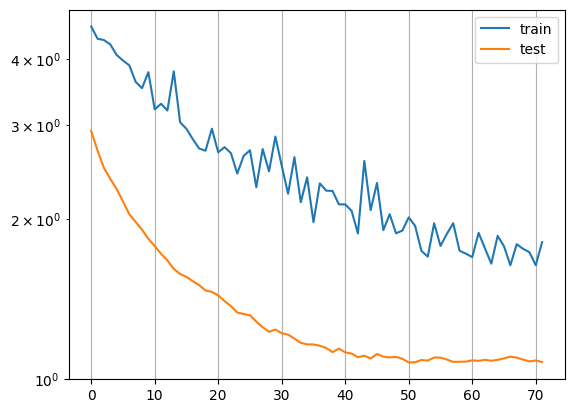

In [22]:
f, ax = plt.subplots()
ax.semilogy()
ax.plot(trrec, label='train')
ax.plot(terec, label='test')

# ax.set_ylim(1e-1)
ax.legend()
ax.grid()

In [29]:
def predict(model, loader):
    true, pred = test(model, loader)
    true = true.detach().cpu().numpy()
    pred = pred.detach().cpu().numpy()
    
    true = true*t_std + t_mu
    pred[:,0] = pred[:,0]*t_std + t_mu
    pred[:,1] = pred[:,1]*(t_std**2)
    return true, pred

true, pred = predict(model, test_loader)
true.shape, pred.shape

((104, 1), (104, 2))

Text(0, 0.5, 'predicted')

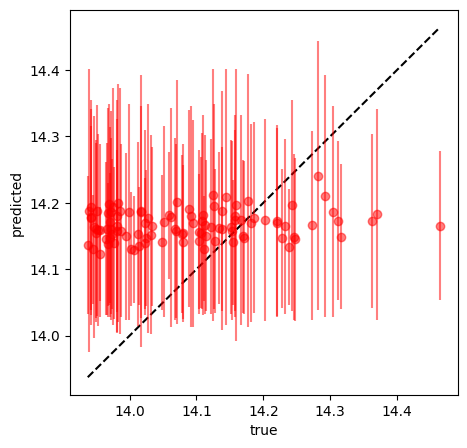

In [30]:
# plot true vs predicted
fig, axs = plt.subplots(1,1, figsize=(5,5))

axs.plot([min(true[:,0]), max(true[:,0])], [min(true[:,0]), max(true[:,0])], c='k', ls='--')
axs.errorbar(true[:,0], pred[:,0], yerr=np.sqrt(pred[:,1]), fmt='ro', alpha=0.5)
axs.set_xlabel('true')
axs.set_ylabel('predicted')
# axs.set_xlim(min(true[:,0]), max(true[:,0]))
# axs.set_ylim(min(true[:,0]), max(true[:,0]))

In [32]:
print(f'Graph-based NLE scatter: {np.std(pred[:,0]-true[:,0]):.4f}')
print(f'Mean prediction scatter: {np.std(np.mean(true)-true[:,0]):.4f}')

Graph-based NLE scatter: 0.1147
Mean prediction scatter: 0.1163
